# Programming Methodologies for Data Analysis: Project 

## Authors
- Lorenzo Dell'Oro
- Giovanni Toto
- Gian Luca Vriz

## 1. Introduction
Nowadays, climate change is one of the main challenges for humankind, with the potential to impact the health of nearly every person on Earth. Thus, it is a subject undergoing intense study, which requires interconnection between different academic fields. 
From this perspective, the aim of this project is to answer the question: how the concept of climate change is seen from a human standpoint?

To pursue this objective we consider for a time period of 10 years all the articles published in one of the most important British newspapers, *The Guardian*.  After a brief exploratory analysis, an Embedded Topic model (*ETM*) and a more flexible Dynamic Embedded Topic Model (*DETM*) will be performed with the goal to find some relevant results. 
In the last section, some conclusions will be drawn as well as new directions for future researchers.

First, we have to import all necessary libraries and functions:

In [40]:
%load_ext autoreload
%autoreload 2

# importing libraries
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
import string
import torch
import xml.etree.ElementTree

# importing functions from libraries
from collections import Counter
from gensim.models import FastText, KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from ipywidgets import fixed, interact, widgets
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# importing functions from modules
from src.exploratory_analysis import most_used_words, top_authors, wordcloud_corpus
from src.file_io import save_embeddings
from src.main_ETM import main_ETM
from src.model_comparison import display_metric, load_metrics
from src.preprocessing import preprocessing
from src.qualitative_analysis import barplot_topwords, visualize_documents, visualize_topics, visualize_top_words

# seaborn setting
sns.set(style='darkgrid')
# topic colors and corpus color for plots
colours = ["#006000", "#800080", "#0000FF", "#632518", "#FF8800", "#FF0000", "#F1E200", "#00AAFF", "#A7D131", "#CC6699"]
alt_colour = '#BCBCBC'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Guardian dataset
*The Guardian* is one of the most important newspapers in the United Kingdom and in the English-speaking world. Its widely recognized reputation makes it one of the most reliable sources about global issues, such as climate change.
Since the latter is one of the most discussed topic in the last years, our aim is to study what are the keywords of the related mainstream public debate and if they changed in the last decade, i.e. between 2013 and 2022.

### 2.i. Download using API
In order to obtain the best dataset according to the needs of our analysis, we downloaded the articles from [The Open Platform](https://open-platform.theguardian.com), the Guardian's official API.

The downloaded articles are selected by the following query:
- type = '*article*', to exclude other types of content, such as video and audio files;
- section = '*environment*', to select only articles published in that section of  the newspaper;
- q = ' "*climate change*" ', to get only the articles that contain those two words in that order;
- the date of the downloaded articles spans from the beginning of 2013 to the end of 2022;
- lang = '*en*' assures that all the selected articles are written in the same language (English), a basic request of text mining;
- order-by, page-size, show-fields and api-key are technical arguments of the query.

We need an API key in order to download the articles: in the following block, you should replace `'test'` with your API key; it can be easily obtained [here](https://open-platform.theguardian.com/access/).

In [2]:
"""
api_key = "test"
query = {'type': 'article',
         'q': '"climate change"',
         'section': 'environment',
         'from-date': "2013-01-01",
         'to-date': "2022-12-31",
         'lang': 'en',
         'order-by': 'oldest',
         'page-size': 200,
         'show-fields': 'all',
         'api-key': api_key}

from src.file_io import download_guardian
corpus = download_guardian(query, 'data/raw/guardian_environment.csv')
"""
corpus = pd.read_csv('data/raw/guardian_environment.csv')

### 2.ii Selection of the variable of interest
`corpus` is a `pandas` dataset containing several pieces of information for each document, most of which are not relevant to our analysis; hence, we keep only the following fields:
- document-related:
    - `id`: identifier;
    - `year`: year of publication on the website (`webPublicationDate`);
    - `where`: original place on which the article was published (`fields_publication`);
    - `author`: author (`fields_byline`);
- text-related:
    - `headline`: title (`fields_headline`);
    - `standfirst`: summary (`fields_standfirst`);
    - `body`: text with tags (`fields_body`);
    - `bodyText`: text without tags (`fields_bodyText`);
- count-related:
    - `wordcount`: number of words in the body (`fields_wordcount`);
    - `charcount`: number of characters in the body without tags (`fields_charcount`);
    
We report in parentheses the original name of the field or, in the case of `year`, the name of the field from which `year` was obtained.

In [3]:
col_of_interest = ['id', 'webPublicationDate', 'fields_publication', 'fields_byline',
                   'fields_headline', 'fields_standfirst', 'fields_body', 'fields_bodyText',
                   'fields_wordcount', 'fields_charCount']
# select columns of interest
corpus = corpus.loc[:, col_of_interest]
# convert 'webPublicationDate' field to year
corpus['webPublicationDate'] = pd.to_datetime(corpus['webPublicationDate']).dt.year
# rename columns
new_colnames = {'webPublicationDate': 'year', 'fields_publication': 'where', 'fields_byline': 'author',
                'fields_headline': 'headline', 'fields_standfirst': 'standfirst', 'fields_body': 'body', 'fields_bodyText':'bodyText',
                'fields_wordcount': 'wordcount', 'fields_charCount': 'charcount'}
corpus.rename(columns=new_colnames, inplace=True)

Then, we remove the articles which do not have a body, i.e. where the value of `bodyText` is `nan`.

In [4]:
corpus = corpus[corpus['bodyText'].isna() == False]

Finally, if an article does not have the `headline` and/or `standfirst`, we replace all `nan` values with empty strings.

In [5]:
corpus['headline'][corpus['headline'].isna() == True] = ''
corpus['standfirst'][corpus['standfirst'].isna() == True] = ''

### 2.ii. Pre-processing of the texts
In this section we consider the texts of the article downloaded in the previous section and we process them in order to make them compatible with *ETM* and *DETM*. In particular, we want to obtain two lists of strings:
- `timestamps` containing the timestamps of the articles, i.e. the years in which they were published;
- `docs` containing the processed texts of the articles, i.e. the headline, standfirst and body.

First, we obtain `timestamps` variable from `year` field:

In [6]:
timestamps = [str(y) for y in corpus['year'].tolist()]

Then, we process the texts in order to obtain an input compatible with text analysis approaches:

In [7]:
# regex for urls; source: https://stackoverflow.com/a/50790119
url_regex = r"\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b"
tag_regex = re.compile('<.*?>')

docs = corpus['headline'] + " " + corpus['standfirst'] + " " + corpus['bodyText']
docs = docs.tolist()
docs = [re.sub(url_regex, '', docs[doc]).lower() for doc in range(len(docs))]
docs = [re.sub(tag_regex, '', docs[doc]) for doc in range(len(docs))]
docs = [[w.translate(str.maketrans('', '', string.punctuation + "0123456789")) for w in docs[doc].split()] for doc in range(len(docs))]
docs = [[w for w in docs[doc] if len(w)>1] for doc in range(len(docs))]
docs = [" ".join(docs[doc]) for doc in range(len(docs))]

Finally, we use `preprocessing` function contained in `src/preprocessing.py` module, which creates files compatible with *ETM* and *DETM*. Before launching the function, we need to import stopwords:

In [8]:
# Read stopwords
with open("./data/stops.txt", "r") as f:
    stopwords = f.read().split('\n')
# Pre-processing
data_path = 'data/guardian_environment'
preprocessing(data_path=data_path, docs=docs, timestamps=timestamps, stopwords=stopwords,
              min_df=50, max_df=0.7, data_split=[0.7, 0.2, 0.1], seed=28)

***************
Preparing data:


ValueError: "path_save" not valid: the folder already exists.

It is best practice in machine learning to split our data into the following three groups:
- *training set*: for training of the model,
- *validation set*: for unbiased evaluation of the model,
- *test set*: for final evaluation of the model.

Adhering to this setup helps ensure that we have a realistic understanding of our model's performance and that we hopefully estimate a model which generalizes well to unseen data. The last function divides the corpus into these three sets, and we are going to consider the training set only for the exploratory analyses in the next section.

## 3. Exploratory data analysis
In this section, we perform *exploratory data analysis* (*EDA*) on the dataset imported by the previous query. *EDA* is an approach to analyse data sets to summarise their main characteristics using statistical graphics and other data visualization methods. 

Before moving on, we remove all variables that are no longer used:

In [9]:
del col_of_interest, docs, new_colnames, url_regex

In this section, we will consider the train set only. Therefore, we replace the whole corpus, stored in the `corpus` variable with the train set (the test and validation sets are useless for now). We also store the vocabulary of the train set in the `vocab` variable.

In [10]:
with open('data/guardian_environment/info.json', 'r') as f:
    info = json.load(f)
    vocab = info['vocab_tr']
    corpus = corpus.iloc[info['indices_tr'], :]
    docs_bow = [[vocab[v] for v in doc] for doc in info['docs_tr']]
    del info

docs_by_year = {}
year_list = sorted(list(set(timestamps)))
for year in year_list:
    docs_by_year[year] = [docs_bow[d] for d in range(len(docs_bow)) if timestamps[d] == year]

First, we implement a bar plot to show the repartition of articles by publication date:

In [11]:
fig = px.bar(corpus.groupby(['year'])['year'].count().reset_index(name='number of articles'), x='year', y='number of articles',
             title="Bar plot by pubblication date", labels=dict(year='year'))
fig.update_traces(marker_color='steelblue')
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.show()

The first two years for the number of published articles were 2015 and 2021. This trend could be the consequence of two main events in the UK's coal industry:
- in 2015, the government announced that all remaining coal-fired power stations would be closed by 2025;
- in 2021, it brought forward its coal phase-out target to 2024.

The least value of publications was in 2020, which coincides with the start of the Covid-19 pandemic across Europe.

The following graph presents the distribution of the articles by the number of words:

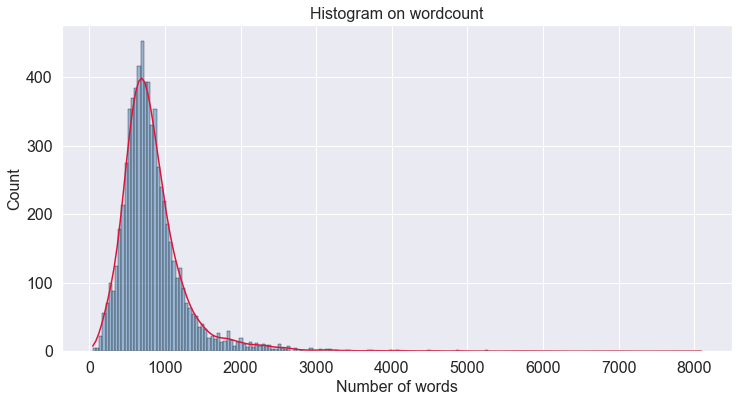

In [12]:
fig, ax = plt.subplots(figsize=(12,6)) 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
sns.histplot(data=corpus, x="wordcount", kde=True, edgecolor='black', color='steelblue')
ax.lines[0].set_color('crimson')
plt.xlabel('Number of words', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Histogram on wordcount', fontsize=16)
plt.show()

We note that the distribution presents a long-right tail, so we restrict the attention only to the articles with a number of words less than 3000 in order to have a better representation:

Documents with more than 3000 words are 51


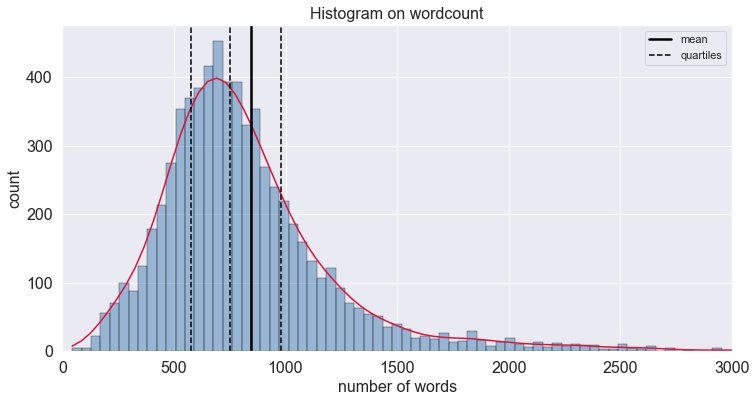

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
print('Documents with more than 3000 words are', len(corpus[corpus['wordcount'] >= 3000]))
sns.histplot(data=corpus, x='wordcount', kde=True, edgecolor='black', color='steelblue')
ax.lines[0].set_color('crimson')
plt.xlabel('number of words', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.title('Histogram on wordcount', fontsize=16)
plt.xlim(0, 3000)
m = plt.axvline(np.mean(corpus['wordcount']), linewidth=2.5, color='black', label='mean')
q_1 = plt.axvline(np.percentile(corpus['wordcount'], 25), linestyle='--', color='black', label='quartiles')
q_2 = plt.axvline(np.percentile(corpus['wordcount'], 50), linestyle='--', color='black')
q_3 = plt.axvline(np.percentile(corpus['wordcount'], 75), linestyle='--', color='black')
plt.legend(handles=[m, q_1])
plt.show()

The distribution has a mean equal to 846 words, while the median is equal to 751 and the mode is 638.
If a frequency distribution has a symmetrical frequency curve, then the mean, median and mode will be equal; however, we have a positively skewed distribution, and therefore the mean is always greater than the median and the median is always greater than the mode.

All the articles can be published through three main routes: directly in *The Guardian* paper magazine, in *The Observer* sub-journal and in the online website *theguardian.com*. The division of all the articles is reported in the below pie chart:

In [14]:
fig = px.pie(corpus.groupby(['where'])['where'].count().reset_index(name='count'), values='count', names='where',
             title='Pie chart on sub-journals', hole=0.35)
fig.update_traces(textposition='outside', textinfo='percent+label',marker=dict(line=dict(color='#000000', width=4)),
                                  pull=[0.00, 0.00, 0.00], opacity=0.9)
fig.show()

With the same reasoning, all articles can be grouped by author. In the following, we show the first 15 authors by the number of publications:

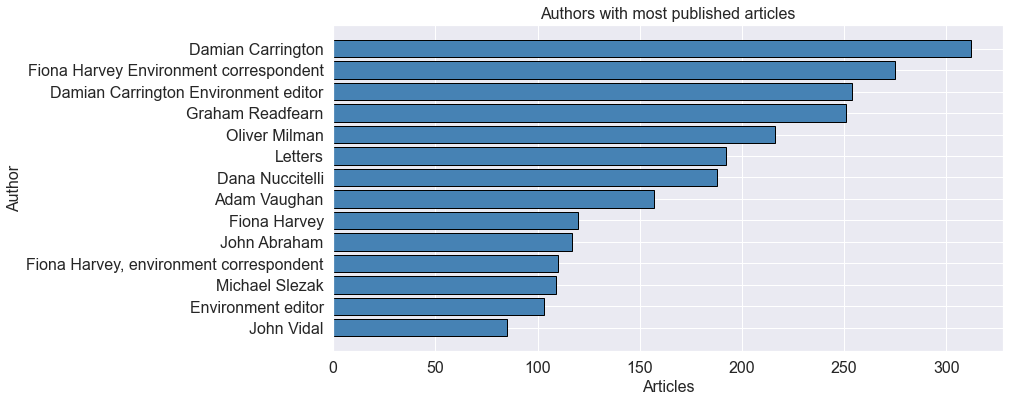

In [15]:
top_authors(corpus, 15)

The last exploratory analysis has the aim to show the 15 most used words in the collection:

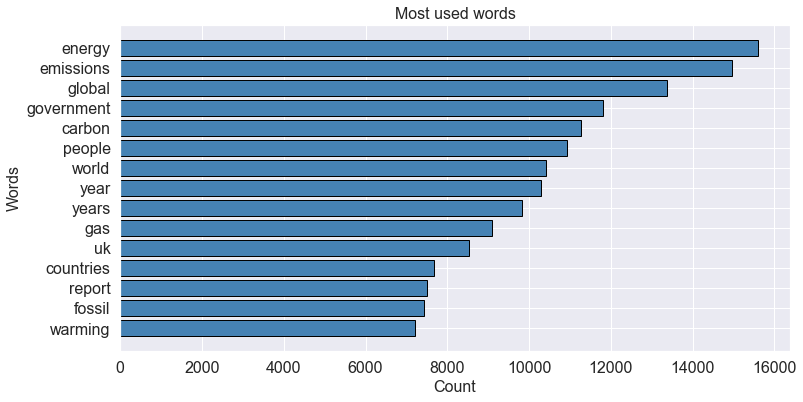

In [16]:
most_used_words(docs_bow, 15)

As can be easily predicted, they are related to the energy crisis, present and future, and how governments and countries are trying to solve it. In particular, it is interesting to note that the first five words are *energy*, *emission*, *global*, *government* and *carbon*: this could mean that the main topic in climate change from 2013 to 2023 was based on the interconnection between government policies and industry in the United Kingdom.

To have a more complete and more impactful representation of word frequencies, we report a *wordcloud* in which colours are random, while the size of each term is proportional to its term frequency.

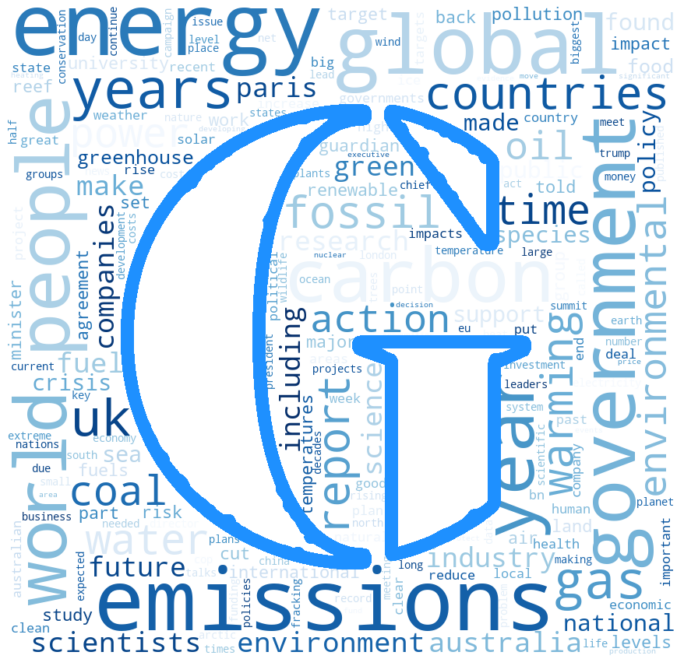

In [17]:
wordcloud_corpus(docs_bow)

Finally, we report also a wordcloud for each year, which considers just the articles published in the specific timeframe:

In [18]:
@widgets.interact(year=year_list)
def get_wordcloud(year):
    docs_bowf_year = [item for sublist in docs_by_year[str(year)] for item in sublist]
    docs_bowf_count_year = Counter(docs_bowf_year)

    tot_dwords_year = {}
    tot_dword_year = dict(sorted(docs_bowf_count_year.items(), key = lambda item: item[1]))

    wordcloud = WordCloud(background_color='white', contour_width=30, colormap='Blues',
                          contour_color='dodgerblue').generate_from_frequencies(tot_dword_year)

    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

interactive(children=(Dropdown(description='year', options=('2013', '2014', '2015', '2016', '2017', '2018', '2…

## 4. Word embeddings
In *Natural Language Processing* (*NLP*), word embedding is a mathematical representation of a word. Commonly, the representation is a real-valued vector that encodes the meaning of the word with the aim that words closer to each other in the vector space are expected to be similar in meaning. We want to use the same embedding space for both *ETM* and *DETM*, so we first fit the word embeddings and then provide them as input to the topic models.

We set here from where the notebook should import the pre-trained embeddings (`pretrained_folder`) and where it should save the input files for `ETM` function (`embedding_folder`):

In [19]:
embedding_folder, embedding_file = 'embeddings/', 'guardian_environment'
embedding_path = embedding_folder + embedding_file
pretrained_folder = embedding_folder + 'pretrained/'

### 4.i. Random embeddings
As a baseline, we introduce the *random embeddings*, i.e. embeddings which are initialized randomly. `ETM` function check if the word embedding of each word is available and, if one or more of them are not, a random vector is sampled from $N(0, 0.6^2)$, i.e. a normal distribution with mean 0 and standard deviation 0.6. Hence, here we just create an empty file that will make `ETM` function sample the word embedding for each word of the vocabulary.

In [20]:
emb_file = embedding_path + '_random.txt'
if not os.path.isfile(emb_file):
    with open(emb_file, 'w') as empty_file: 
        pass

### 4.ii. Word2vec on train corpus
*Word2vec* is a group of related models that are used to produce word embeddings, created and published by a team of researchers in *Google* over two papers (Mikolov et al., 2013a, 2013b). *Word2vec* can utilize either of two model architectures to produce the word embeddings: *Continuous Bag-Of-Words* (*CBOW*) or *skip gram*. In both architectures, *word2vec* considers both individual words and a sliding window of context words:
- in the *CBOW* architecture, the model predicts the current word from the window of surrounding context words;
- in the *skip gram* architecture, the model uses the current word to predict the surrounding window of context words.

We use `Word2Vec` function of `gensim` library to train 300-dimensional word embeddings on the train set using *CBOW* and *skip gram* with a windows size of 10 (`window`) and 5 noise words in the negative sampling (`negative`). The models run for 10 iterations and compute the word embeddings for each word selected in the pre-processing step.

In [21]:
# sg=0: CBOW
emb_file = embedding_path + '_cbow.txt'
if not os.path.isfile(emb_file):
    cbow = Word2Vec(sentences=docs_bow, min_count=1, sg=0, size=300, iter=10, workers=5, negative=5, window=10)
    save_embeddings(emb_model=cbow, emb_file=emb_file, vocab=vocab)
    del cbow
# sg=1: skipgram
emb_file = embedding_path + '_skipgram.txt'
if not os.path.isfile(emb_file):
    skipgram = Word2Vec(sentences=docs_bow, min_count=1, sg=1, size=300, iter=10, workers=5, negative=5, window=10)
    save_embeddings(emb_model=skipgram, emb_file=emb_file, vocab=vocab)
    del skipgram

### 4.iii. FastText on train corpus
*FastText* (Bojanowski et al., 2017), which can be considered an extension of *word2vec*, treats each word as composed of character $n$-grams.
So, instead of producing the word embeddings only for complete words, the model produces the word embeddings for all the $n$-grams and then produces each word as the sum of the $n$-grams contained in it.

We use `FastText` function of `gensim` library to train 300-dimensional word embeddings on the train set using *FastText* with a window size of 10 (`window`) and 5 noise words in the negative sampling (`negative`). The model runs for 10 iterations and computes the word embeddings for each word selected in the pre-processing step.

In [22]:
emb_file = embedding_path + '_fasttext.txt'
if not os.path.isfile(emb_file):
    fasttext = FastText(sentences=docs_bow, min_count=1, size=300, iter=10, negative=5, window=10)
    save_embeddings(emb_model=fasttext, emb_file=emb_file, vocab=vocab)
    del fasttext

### 4.iv. Google’s Word2vec
We use the word embeddings trained on part of the Google News dataset (about 100 billion words) using a simple data-driven approach described in Mikolov et al. (2013b). The model contains 300-dimensional vectors for 3 million words and phrases; however, we just keep the ones which are in the vocabulary of the train set. You can find out more [here](https://code.google.com/archive/p/word2vec/) and use this [link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) to download the pre-trained word embeddings. 

First, you need to download `GoogleNews-vectors-negative300.bin.gz` using the link above, unzip it and copy `GoogleNews-vectors-negative300.bin` in `embeddings/pretrained` folder , then you can use `gensim` library to load the word embeddings and finally create the input file for `ETM` function.

In [23]:
emb_file = embedding_path + '_google_word2vec.txt'
if not os.path.isfile(emb_file):
    google_word2vec = KeyedVectors.load_word2vec_format(pretrained_folder+'GoogleNews-vectors-negative300.bin', binary=True)
    save_embeddings(emb_model=google_word2vec, emb_file=emb_file, vocab=vocab)
    del google_word2vec

### 4.v. Stanford’s GloVe
Citing the [official website](https://nlp.stanford.edu/projects/glove/), *GloVe* (Pennington et al., 2014) is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
There are four pre-trained word vectors available: here we use a 300-dimensional version of *Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download)*, which can be downloaded using this [link](https://nlp.stanford.edu/data/glove.6B.zip).

First, you need to download `glove.6B.zip` folder using the link above, unzip it and copy `glove.6B.300d.txt` in `embeddings/pretrained` folder , then you can use `gensim` library to create a `.bin` file from the one downloaded, load the word embeddings and finally create the input file for `ETM` function.

In [24]:
emb_file = embedding_path + '_glove.txt'
# create word2vec file if it does not exist
glove_input_file = pretrained_folder + 'glove.6B.300d.txt'
word2vec_output_file = pretrained_folder + 'glove.6B.300d.bin'
if not os.path.isfile(word2vec_output_file):
    glove2word2vec(glove_input_file, word2vec_output_file)
# load and save embeddings
if not os.path.isfile(emb_file):
    glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    save_embeddings(emb_model=glove, emb_file=emb_file, vocab=vocab)
    del glove
del emb_file, glove_input_file, word2vec_output_file

## 5 Embedded Topic Model
Topic modelling is a branch of *NLP* whose objective is to analyze documents to learn the most relevant patterns of words.

The *Embedded Topic Model* (*ETM*) is a document model that marries LDA and word embeddings, which enjoys the good
properties of both topic models and word embeddings: as a topic model, it discovers an interpretable latent semantic structure of the documents, i.e. the topic-word and document-topic distribution, and as a word embedding model it provides a low-dimensional representation of the meaning of words, i.e. the word embeddings.
Like *LDA*, the *ETM* is a generative probabilistic model: each document is a mixture of topics and each observed word is assigned to a particular topic. In contrast to *LDA*, the per-topic conditional probability of a term has a log-linear form that involves a low-dimensional representation of the vocabulary. Each term is represented by an embedding and each topic is a point in that embedding space. The topic’s distribution over terms is proportional to the exponentiated inner product of the topic’s embedding and each term’s embedding (Dieng et al., 2020).

In [25]:
save_path = 'results'

epochs = 100
batch_size = 1000

topics_list = [10, 20, 30, 40, 50]
# dict('emb_name': emb_size)
embedding_list = {'cbow': 300, 'skipgram': 300, 'fasttext': 300, 'google_word2vec': 300, 'glove': 300, 'random': 300}

Wall time: 2h 16min 38s

In [26]:
%%time
for emb_name, emb_size in embedding_list.items():
    for topics in topics_list:
        dataset = data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        emb_file = embedding_path + '_' + emb_name + '.txt'
        model_file = 'ETM_' + data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        #main_ETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
        #         rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='train', num_topics=topics,
        #         train_embeddings=0, epochs=epochs, tc=False, td=False)

Wall time: 0 ns


## 6. Model comparison
The unsupervised nature of topic models provides them with great flexibility, but at the same time the absence of annotations makes their evaluation more difficult.

The most common approach for assessing the quality of topics identified by a model is considering *topic coherence* metrics, which are based on the intuition that a human perceives a topic to be informative and coherent if its top words tend to be used together since they are somehow related to each other. Airoldi et al. (2014) propose a general formulation for calculating the topic coherence of a single topic.

Another useful metric is *topic diversity*, defined as the percentage of unique words in the top 25 words of
all topics, which is based on the idea that if topics really cover all themes of the corpus, then their top words should be different.


The following block allows to evaluate the model trained in the previous section; in particular, it saves a file, called `<model_name>_parameters.pt` containing:
- `tc` contains the topic coherence computed on the top 10 words of each topic
- `td` contains the topic diversity on the top 25 words of each topic
- `rho` contains the word embeddings (row=embedding)
- `model.alphas.weight` contains the topic embeddings (row=embedding)
- `beta` contains the topic-word distributions (row=distribution)
- `theta` contains the document-topic distribution (row=distribution)

Wall time: 1h 20min 6s

In [27]:
%%time
for emb_name, emb_size in embedding_list.items():
    for topics in topics_list:
        dataset = data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        emb_file = embedding_path + '_' + emb_name + '.txt'
        model_file = 'ETM_' + data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        #main_ETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
        #         load_from=save_path+'/'+model_file,
        #         rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='eval', num_topics=topics,
        #         train_embeddings=0, epochs=epochs, num_words=10, tc=True, td=True)

Wall time: 997 µs


Now, we save the metrics in 3 matrices and in the next we try to interpret the results.

### 6.i. Quantitative analysis

To measure the performance of our approach we are going to compare the proposed metrics:
- topic coherence,
- topic diversity,
- topic quality (it is defined as the product between topic coherence and diversity (Dieng et al., 2019)).

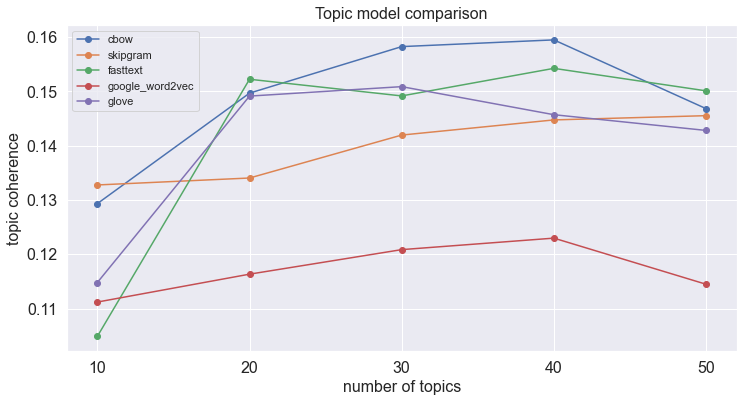

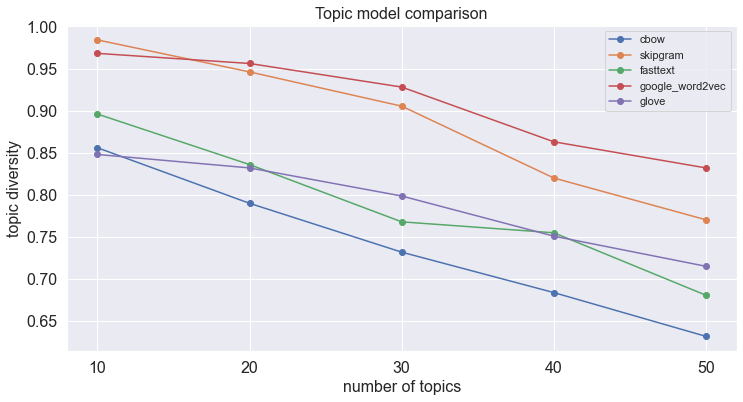

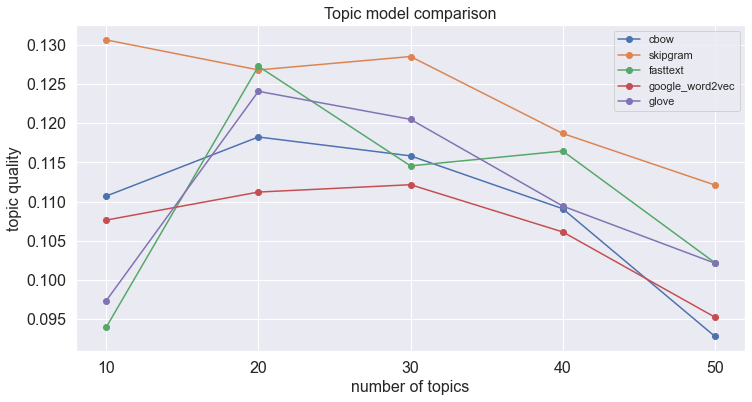

In [28]:
topics_list = [10, 20, 30, 40, 50]
embedding_list = {'cbow': 300, 'skipgram': 300, 'fasttext': 300, 'google_word2vec': 300, 'glove': 300}#, 'random': 300}

etm_tc, etm_td, etm_tq = load_metrics(topics_list, embedding_list, data_path, save_path)
    
display_metric(etm_tc, 'topic coherence')
display_metric(etm_td, 'topic diversity')
display_metric(etm_tq, 'topic quality')

Considering all three metrics, we have that:
- the model with the `cbow` and `fasttext` word embedding turn out to be the best ones in terms of topic coherence for a number of topics of 30 or 40 and 20 or 50 respectively;
- the model with the `google_word2vec` word embedding turns out to be the best one in terms of topic diversity;
- the model with the `skipgram` word embedding turns out to be the best one in terms of topic quality.

### 6.ii. Qualitative analysis

Considering the metric topic quality, we now perform a qualitative analysis on the model built considering the *skip gram* word embedding architecture. 

In [29]:
model_file = 'ETM_' + data_path.split("/")[-1] + '_skipgram_10_parameters.pt'
best_model = torch.load(save_path + '/' + model_file)

theta = best_model['theta']
alpha = best_model['alpha']
rho = best_model['rho']
beta = best_model['beta']
vocab = best_model['vocab']
num_topics = alpha.shape[0]

Firstly, we do a graphical representation of a document as a mixture of topics:

In [31]:
interact(visualize_documents, theta=fixed(theta), doc=widgets.IntSlider(min=0,max=theta.shape[0]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='doc', max=6844), Output()), _dom_classes=('widget-intera…

<function src.qualitative_analysis.visualize_documents(theta, doc)>

Then, we explore the presence of topics in the documents:

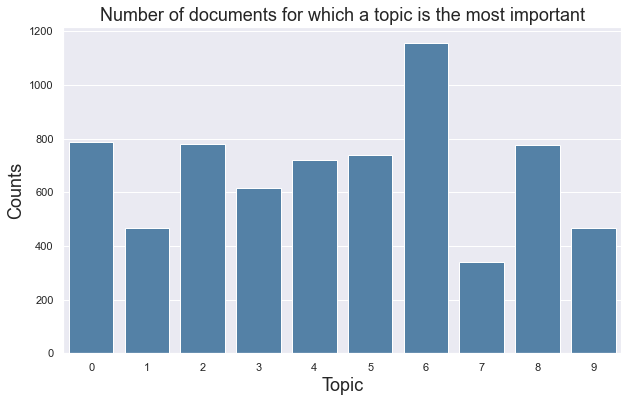

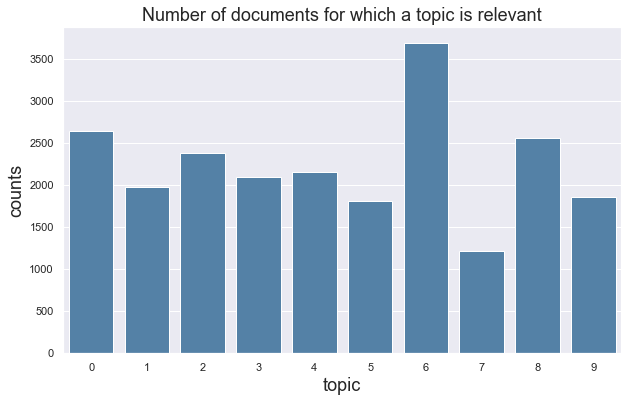

In [32]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS THE MOST IMPORTANT
top_topics=list(np.argsort(-1 * theta, axis=1)[:,1])
count_top_topics = list()
for i in range(theta.shape[1]):
    count_top_topics.append((np.array(top_topics)==i).sum(axis=0))
data = {'topic': list(range(theta.shape[1])), 'counts': count_top_topics}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='counts', data=df, color='steelblue')
plt.title('Number of documents for which a topic is the most important', fontsize=18)
plt.xlabel('Topic', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.show()

# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS DETECTED (theta above a threshold)
theta_threshold=1/theta.shape[1]
topic_ndocs=(theta>theta_threshold).sum(axis=0)
data = {'topic': list(range(theta.shape[1])), 'ndocs': list(topic_ndocs)}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='ndocs', data=df, color='steelblue')
plt.title("Number of documents for which a topic is relevant", fontsize=18)
plt.xlabel('Topic', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.show()

Considering the number of documents in which a topic is a leading one, we have that the three most relevant topics are:
- *topic 6*;
- *topic 0*;
- *topic 2*.

We also perform a T-SNE, which is a nonlinear dimensionality reduction technique that is well suited for embedding high-dimension data into lower dimensional data (2D or 3D) for data visualization:

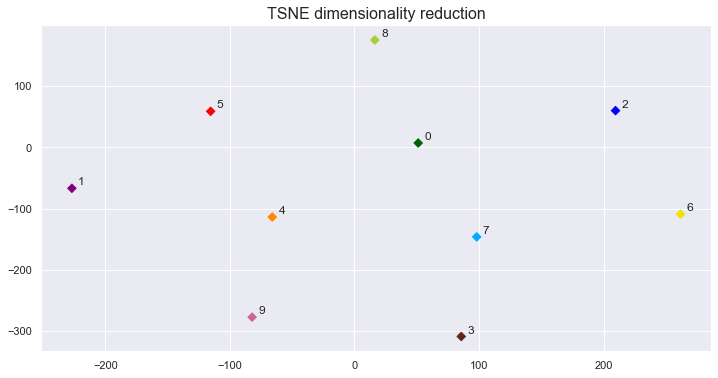

In [33]:
visualize_topics(alpha, colours, annotations=[5,5])

In [38]:
# tsne
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_words = tsne_model.fit_transform(rho)
# plot
visualize_top_words(tsne_words, beta, rho, colours, alt_colour, topwords=10)

alt.HConcatChart(...)

Finally, we show the most relevant words of each topic:

In [41]:
interact(barplot_topwords, topic=list((range(num_topics))), beta=fixed(beta), vocab=fixed(vocab), topwords=list((10,15,20)))

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown…

<function src.qualitative_analysis.barplot_topwords(topic, beta, vocab, topwords=10)>

The previous graph may be useful to interpret every single topic provided by the model. Considering *topic 6*, the most relevant words regard spatial-temporal concepts. For *topic 0*, they are connected to energy markets and their externalities. While *topic 2* refers to climate change impacts and world adaptation to them.

## 7. Dynamic Embedded Topic Model (DETM)

As proposed by Dieng et al. (2019), we have also tried to perform a DETM. It is a model that combines and at the same
time extends the framework of Dynamic Latent Dirichlet Allocation (DLDA) with that of ETM.

Similarly, to DLDA, the DETM involves a probabilistic time series to allow the topics to vary smoothly over time. However, in this case, each topic is a time-varying vector on the word embedding space.
On the other hand, the probability of each word under the DETM is a categorical distribution whose natural parameter depends on the inner product between the word’s embedding and a per-topic embedding representation of its assigned topic (as in the ETM).

### 7.i. Model Estimation
**Memory problems:** DETM rquires too much memory!

In [ ]:
#from src.main_DETM import main_DETM
#main_DETM(dataset='un-general-debates', data_path='data/un-general-debates', save_path='data',
#          emb_path='data/un-general-debates_embeddings.txt', mode='train', batch_size=1000,
#          num_topics=50, train_embeddings=0, epochs=200, visualize_every=1000, tc=True)

## 8. Conclusions

In this work, we studied climate change sensitivity. Considering the *environment* section, the set of data under study involved all articles published in the British newspaper, *The Guardian* for the last 10 years. Through the exploratory analysis, we have seen that all papers are homogeneously distributed across the years. Moreover, there are also some words which seem to be relevant almost every year:
- *energy*;
- *emission*;
- *global*;
- *government*;

After, we develop several ETMs with different types of word embeddings. Performing a qualitative analysis on the best one was useful to identify the most relevant topics. The first three represent ideas regarding spatial-temporal concepts, energy market features and climate change impacts.

To shed more light on this issue the results provided by a Dynamic Embedded Topic Model could have a crucial role, but it is computationally expensive.
Anyway, the concept of government intervention as well as that of international agreements to green the Earth may be increased in the last years because of a greater sense of collaboration in this field.

### 8.i. Future work

We could consider a wider variety of word embeddings both fitted on the corpus or pre-trained on much wider corpuses. Here, we did not tune the parameters of *Word2vec* and *FastText*, however we could have optimized various parameters, such as the vector size, the window size, the number of *noise words* of the *negative sampling*, and so on.
As for the pre-trained word embeddings, we could consider the ones made available by *FastText* (see [here](https://fasttext.cc/docs/en/english-vectors.html)) or other versions of *GloVe* (see [here](https://nlp.stanford.edu/projects/glove/)); alternatively, we could consider the approach proposed in Gupta & Jaggi (2021) in which dynamic word embeddings are converted into static ones.

## References

Airoldi, E. M., Blei, D., Erosheva, E. A., & Fienberg, S. E. (2014). Handbook of Mixed Membership Models and Their Applications. [ACM Digital Library](https://dl.acm.org/doi/book/10.5555/2765552)

Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the association for computational linguistics, 5, 135-146. [MIT Press Direct](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00051/43387/Enriching-Word-Vectors-with-Subword-Information)

Dieng, A. B., Ruiz, F. J., & Blei, D. M. (2019). The dynamic embedded topic model. arXiv preprint arXiv:[1907.05545](https://arxiv.org/abs/1907.05545).

Dieng, A. B., Ruiz, F. J., & Blei, D. M. (2020). Topic modeling in embedding spaces. Transactions of the Association for Computational Linguistics, 8, 439-453. [ACM Anthology](https://aclanthology.org/2020.tacl-1.29/),  [Arxiv link](https://arxiv.org/abs/1907.04907)

Gupta, P., & Jaggi, M. (2021). Obtaining better static word embeddings using contextual embedding models. arXiv preprint arXiv:[2106.04302](https://arxiv.org/abs/2106.04302).

Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013a). Efficient estimation of word representations in vector space. arXiv preprint arXiv:[1301.3781](https://arxiv.org/abs/1301.3781).

Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013b). Distributed representations of words and phrases and their compositionality. Advances in neural information processing systems, 26. [ACM Digital Library](https://dl.acm.org/doi/abs/10.5555/2999792.2999959)

Pennington, J., Socher, R., & Manning, C. D. (2014, October). Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP) (pp. 1532-1543). [ACL Anthology](https://aclanthology.org/D14-1162/)